In [45]:
# Imports
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.functional import normalize

print('CUDA support') if torch.cuda.is_available() else print('No CUDA support') 

No CUDA support


### Dataloader
PyTorch makes it a bit harder to load in custom data.  
I will read the data with pandas

In [4]:
# Read csv file
math_df = pd.read_csv("../Data/Math_Test_Results_Cleaned.csv")

# X -> features  
# y -> labels
X = math_df.drop('Mean Scale Score', axis=1)
y = math_df['Mean Scale Score']

Next create a custom dataset  
This just converts the X and y values to torch tensors and wraps it in a class  
Not really needed in this simple case but just following the guidelines

In [5]:
class MathDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y)
        
        self.X = self.X.to(torch.float32)
        self.y = self.y.to(torch.float32)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

Use the class to process the data

In [6]:
torch_dataset = MathDataset(X, y)
print("length of the dataset is:", len(torch_dataset))

length of the dataset is: 25391


Split the data into train and test data, the pytorch way

In [7]:
train_data, test_data = random_split(torch_dataset, [20000, 5391])

print("The length of train data is:",len(train_data))
print("The length of test data is:",len(test_data))

The length of train data is: 20000
The length of test data is: 5391


In [8]:
print(train_data[0])

(tensor([7.0000e+00, 2.0090e+03, 3.4000e+02, 1.0000e+00, 3.0000e-01, 1.6000e+01,
        4.7000e+00, 1.9200e+02, 5.6500e+01, 1.3100e+02, 3.8500e+01, 3.0000e+01,
        3.0000e+00, 1.4100e+02]), tensor(691.))


This data is not normalized yet.  
I will do this with the sklearn StandardScaler.  

In [9]:
scaler = StandardScaler()
train_data.dataset.X = scaler.fit_transform(train_data.dataset.X)
test_data.dataset.X = scaler.transform(test_data.dataset.X)

In [10]:
print(train_data[0])

(array([-2.44268935e+00, -1.00857901e+03, -1.19035767e+00, -7.16707292e-01,
       -8.14968359e-01, -9.19924737e-01, -1.65946676e+00, -1.05567443e+00,
       -2.57980308e+00, -6.41264235e-01, -1.04929359e+00, -1.21812497e+00,
       -5.59778364e-01, -1.22071398e+00]), tensor(691.))


There we go!  
Next I will need mini-batches  
This is done with the DataLoader class to make things simple

In [11]:
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=20, shuffle=True)

Now we have our data ready for use.  

### First modelling
In Pytorch, this is also done in a seperate class  
This one inherits from the Module class  
I will start with a very simple linear model to get the pipeline started

In [12]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(14, 1)
    
    def forward(self, x):
        y = self.linear(x).to(torch.float32)
        return y

We also need a class that trains our model:

In [13]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        optimizer.zero_grad() # Clear the gradients
        yres = model(x) # Compute model output
        loss = loss_fn(y, yres) # Calculate loss
        loss.backward() # Backpropagating the error
        optimizer.step() # Update parameters (weights)
        return loss.item()
    return train_step

And this is a simple implementation

In [14]:
model = LinearModel()
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train_step = make_train_step(model, loss_fn, optimizer)

for x_batch, y_batch in train_loader:
    loss = train_step(x_batch.to(torch.float32), y_batch)
    print(loss)

790372.6875
326958982365184.0
1.3532770143253578e+23
5.600640452272461e+31
inf
inf
inf
inf
inf
inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/home/brechtl/miniconda3/envs/aiframeworks/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


Mmh... this is an exploding gradient.  
There is probably something wrong with the data and not the model because this is just a very simple linear model.  
Let's look at the data again

In [15]:
train_data.dataset.X[0]

array([-3.90454249e+00, -1.00933504e+03, -1.22474556e+00, -7.12020905e-01,
       -7.86946161e-01, -9.24670015e-01, -1.57459180e+00, -1.14464435e+00,
       -2.59894656e+00, -7.50612992e-01, -1.11641478e+00, -1.34497354e+00,
       -2.86343473e+00, -1.22606984e+00])

In [16]:
print(train_data.dataset.X.mean())
print(train_data.dataset.X.std())

-73.31579732283028
259.3916008613597


The data should be normalized but there is a weird outlier value (Year) and the mean/std is also not good.  
Load the data again to begin with:

In [17]:
math_df = pd.read_csv("../Data/Math_Test_Results_Cleaned.csv")
X = math_df.drop('Mean Scale Score', axis=1)
y = math_df['Mean Scale Score']

torch_dataset = MathDataset(X, y)
train_data, test_data = random_split(torch_dataset, [20000, 5391])

print(train_data.dataset.X.mean())
print(train_data.dataset.X.std())

tensor(182.1150)
tensor(511.6770)


And now normalize with the implemented normalize function in Pytorch.

In [18]:
train_data.dataset.X = normalize(train_data.dataset.X, p=2.0, dim=0)
test_data.dataset.X = normalize(test_data.dataset.X, p=2.0, dim=0)

print(train_data.dataset.X.mean())
print(train_data.dataset.X.std())

tensor(0.0048)
tensor(0.0040)


In [19]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=80, shuffle=True)

Much better. 

tensor([0.0035, 0.0063, 0.0054, 0.0032, 0.0027, 0.0036, 0.0040, 0.0079, 0.0090,
        0.0013, 0.0016, 0.0075, 0.0090, 0.0035])
epoch 0, MSE: 134194.671875, val MSE: 125769.8515625
tensor([0.0058, 0.0063, 0.0022, 0.0000, 0.0000, 0.0001, 0.0004, 0.0017, 0.0047,
        0.0049, 0.0144, 0.0067, 0.0090, 0.0050])
epoch 1, MSE: 40070.1640625, val MSE: 38848.0859375
tensor([0.0070, 0.0063, 0.0022, 0.0046, 0.0095, 0.0029, 0.0078, 0.0014, 0.0039,
        0.0006, 0.0018, 0.0023, 0.0030, 0.0107])
epoch 2, MSE: 12670.7236328125, val MSE: 11426.18359375
tensor([0.0093, 0.0063, 0.0018, 0.0039, 0.0100, 0.0023, 0.0077, 0.0013, 0.0045,
        0.0001, 0.0005, 0.0015, 0.0000, 0.0081])
epoch 3, MSE: 3290.552734375, val MSE: 3745.8359375
tensor([0.0046, 0.0063, 0.0016, 0.0000, 0.0000, 0.0011, 0.0043, 0.0012, 0.0046,
        0.0025, 0.0102, 0.0018, 0.0030, 0.0006])
epoch 4, MSE: 1665.5352783203125, val MSE: 1152.6820068359375
tensor([0.0035, 0.0063, 0.0043, 0.0032, 0.0034, 0.0040, 0.0055, 0.0056, 0.0078,


Text(0.5, 1.0, 'Train x validation loss')

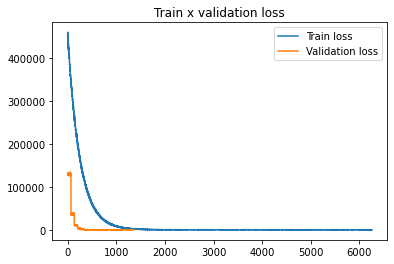

In [20]:
model = LinearModel()
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_step = make_train_step(model, loss_fn, optimizer)

losses = []
val_losses = []

for epoch in range(20):
    for x_batch, y_batch in train_loader:
        # unsqeeze the tensor to add another dimension
        x_batch = x_batch.to(torch.float32)
        y_batch = y_batch.to(torch.float32).unsqueeze(-1)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val = x_val.to(torch.float32)
            y_val = y_val.to(torch.float32).unsqueeze(-1)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
    
    print(x_batch[0])
    print('epoch {}, MSE: {}, val MSE: {}'.format(epoch, loss, val_loss))
    
plt.plot(losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Train x validation loss")

Because we use the mini-batches and a simple model, it doesn't take long to reach a good model state with 'low' training and validation loss

In [21]:
# convert row to data
row = torch.Tensor([0.0070, 0.0063, 0.0043, 0.0004, 0.0004, 0.0007, 0.0010, 0.0050, 0.0072,
        0.0061, 0.0093, 0.0005, 0.0000, 0.0067])
# make prediction
yhat = model(row)
# retrieve numpy array
yhat = yhat.detach().numpy()
print(yhat)

[673.4541]


### Changing the model
I will add some layers to the simple model.  
The simple model did not work that well so it could be a complexity issue.

In [22]:
from torch.nn.init import xavier_uniform_

class Regressor(torch.nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.hidden1 = torch.nn.Linear(14, 10)
        xavier_uniform_(self.hidden1.weight)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.hidden2 = torch.nn.Linear(10, 8)
        xavier_uniform_(self.hidden2.weight)
        self.sigmoid2 = torch.nn.Sigmoid()
        self.hidden3 = torch.nn.Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
        
    
    def forward(self, X):
        # First hidden layer
        X = self.hidden1(X)
        X = self.sigmoid1(X)
        # Second hidden layer
        X = self.hidden2(X)
        X = self.sigmoid2(X)
        # Third hidden layer
        X = self.hidden3(X)
        
        return X

epoch 0, MSE: 513.1994018554688, val loss: 726.5034790039062
epoch 1, MSE: 582.1410522460938, val loss: 466.93780517578125
epoch 2, MSE: 312.62042236328125, val loss: 628.6344604492188
epoch 3, MSE: 509.49493408203125, val loss: 627.052490234375
epoch 4, MSE: 555.801025390625, val loss: 532.0841674804688
epoch 5, MSE: 691.6475830078125, val loss: 1039.2259521484375
epoch 6, MSE: 743.038818359375, val loss: 402.0419006347656
epoch 7, MSE: 579.8347778320312, val loss: 566.680908203125
epoch 8, MSE: 561.012939453125, val loss: 911.6326293945312
epoch 9, MSE: 534.5084228515625, val loss: 301.80572509765625
epoch 10, MSE: 515.9525146484375, val loss: 564.2644653320312
epoch 11, MSE: 463.56048583984375, val loss: 673.2403564453125
epoch 12, MSE: 1089.829345703125, val loss: 370.0843200683594
epoch 13, MSE: 700.0992431640625, val loss: 514.23583984375
epoch 14, MSE: 546.2403564453125, val loss: 430.3384094238281
epoch 15, MSE: 679.6637573242188, val loss: 332.1888122558594
epoch 16, MSE: 634.

Text(0.5, 1.0, 'Train x validation loss')

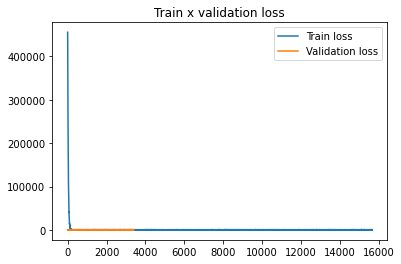

In [23]:
model = Regressor()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_step = make_train_step(model, loss_fn, optimizer)

losses = []
val_losses = []

for epoch in range(50):
    for x_batch, y_batch in train_loader:
        # unsqeeze the tensor to add another dimension
        x_batch = x_batch.to(torch.float32)
        y_batch = y_batch.to(torch.float32).unsqueeze(-1)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    # Evaluate the model with test data
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val = x_val.to(torch.float32)
            y_val = y_val.to(torch.float32).unsqueeze(-1)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
    
    print('epoch {}, MSE: {}, val loss: {}'.format(epoch, loss, val_loss))
    
plt.plot(losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Train x validation loss")

In [24]:
# convert row to data
row = torch.Tensor([0.003, 0.000004, 011111.14, 0.0007, 0.0013, 0.0039, 0.0096, 0.0023, 0.0057,0.0006, 0.0016, 0.0059, 0.0060, 0.0046])
# make prediction
yhat = model(row)
# retrieve numpy array
yhat = yhat.detach().numpy()
print(yhat)

[671.8811]


tensor([0.0093, 0.0063, 0.0234, 0.0189, 0.0037, 0.0332, 0.0085, 0.0148, 0.0038,
        0.0163, 0.0045, 0.0075, 0.0090, 0.0062])
tensor(675.)
tensor([0.0046, 0.0063, 0.0036, 0.0021, 0.0027, 0.0052, 0.0086, 0.0025, 0.0042,
        0.0024, 0.0043, 0.0069, 0.0090, 0.0027])
tensor(679.)
tensor([0.0058, 0.0063, 0.0083, 0.0032, 0.0018, 0.0057, 0.0041, 0.0065, 0.0048,
        0.0115, 0.0090, 0.0062, 0.0090, 0.0032])
tensor(695.)
tensor([0.0081, 0.0063, 0.0055, 0.0007, 0.0006, 0.0010, 0.0011, 0.0050, 0.0055,
        0.0102, 0.0119, 0.0005, 0.0000, 0.0066])
tensor(695.)
tensor([0.0035, 0.0063, 0.0066, 0.0004, 0.0002, 0.0009, 0.0008, 0.0110, 0.0101,
        0.0048, 0.0047, 0.0077, 0.0090, 0.0055])
tensor(689.)
tensor([0.0093, 0.0063, 0.0131, 0.0256, 0.0090, 0.0208, 0.0095, 0.0074, 0.0034,
        0.0018, 0.0009, 0.0080, 0.0121, 0.0013])
tensor(656.)
tensor([0.0058, 0.0063, 0.0090, 0.0028, 0.0015, 0.0046, 0.0031, 0.0112, 0.0076,
        0.0079, 0.0057, 0.0069, 0.0090, 0.0028])
tensor(693.)
tensor

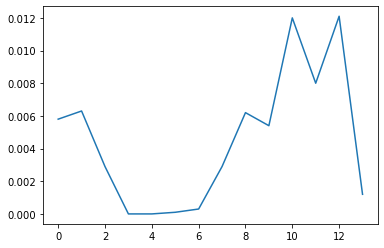

In [25]:
for x_val, y_val in test_loader:
    print(x_val[1])
    print(y_val[1])
    
plt.plot([0.0058, 0.0063, 0.0029, 0.0000, 0.0000, 0.0001, 0.0003, 0.0029, 0.0062,
        0.0054, 0.0120, 0.0080, 0.0121, 0.0012])
plt.show()

### Debugging in seperate IDE
There is clearly something else wrong.  
I really don't like Notebooks for debugging and unit testing so I did this in Spyder IDE.  
I knew that a linear model would give a good result and I tested this with sklearn here:

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(train_data.dataset.X, train_data.dataset.y)
y_pred = reg.predict(test_data.dataset.X)
print("MSE: " + str(mean_squared_error(test_data.dataset.y, y_pred)))
print("r2-score: " + str(reg.score(test_data.dataset.X, test_data.dataset.y)))

MSE: 32.505882
r2-score: 0.9429696296134678


And this is the full debugged model

#### Dataloader

In [43]:
class CSVDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path)
        # store the inputs and outputs
        self.X = df.drop('Mean Scale Score', axis=1)
        self.y = df['Mean Scale Score']
        # ensure target has the right shape
        self.y = self.y.values.reshape((-1, 1))
        
        # Scale the data
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        self.X = torch.tensor(self.X.astype(np.float32))
        self.y = torch.tensor(self.y.astype(np.float32))
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

#### Model

In [48]:
class Regressor(torch.nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(Regressor, self).__init__()
        # input to first hidden layer
        self.hidden1 = torch.nn.Linear(n_inputs, 1)

 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        return X

#### Prepare data

In [37]:
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=80, shuffle=True)
    test_dl = DataLoader(test, batch_size=120, shuffle=False)
    return train_dl, test_dl

#### Model training

In [54]:
def train_model(train_dl, model):
    # define the optimization
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.08)
    # enumerate epochs
    for epoch in range(40):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        print('epoch {}, MSE: {}'.format(epoch, loss))

#### Model evaluation

In [58]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
        
        predictions, actuals = np.vstack(predictions), np.vstack(actuals)
        
        print("r2-score:" + str(r2_score(actuals, predictions)))
        
        # calculate mse
        mse = mean_squared_error(actuals, predictions)
        return mse

#### Main code

In [60]:
path = "/home/brechtl/OneDrive/Lessen/AI Frameworks/Project/Data/Math_Test_Results_Cleaned.csv"
train_dl, test_dl = prepare_data(path)

# define the network
model = Regressor(14)

# train the model
train_model(train_dl, model)
# evaluate the model
mse = evaluate_model(test_dl, model)
print('MSE: %.3f, RMSE: %.3f' % (mse, np.sqrt(mse)))

epoch 0, MSE: 29.48101043701172
epoch 1, MSE: 23.038066864013672
epoch 2, MSE: 30.972501754760742
epoch 3, MSE: 31.821786880493164
epoch 4, MSE: 19.491575241088867
epoch 5, MSE: 29.000083923339844
epoch 6, MSE: 34.038578033447266
epoch 7, MSE: 30.084585189819336
epoch 8, MSE: 24.020633697509766
epoch 9, MSE: 38.53847122192383
epoch 10, MSE: 40.17539596557617
epoch 11, MSE: 38.84812545776367
epoch 12, MSE: 41.76333999633789
epoch 13, MSE: 30.109004974365234
epoch 14, MSE: 51.634727478027344
epoch 15, MSE: 36.69435501098633
epoch 16, MSE: 31.14822769165039
epoch 17, MSE: 22.152584075927734
epoch 18, MSE: 31.21400260925293
epoch 19, MSE: 37.31541442871094
epoch 20, MSE: 30.94044303894043
epoch 21, MSE: 38.02506637573242
epoch 22, MSE: 22.468549728393555
epoch 23, MSE: 30.825918197631836
epoch 24, MSE: 40.58780288696289
epoch 25, MSE: 48.1026611328125
epoch 26, MSE: 34.92483139038086
epoch 27, MSE: 27.762123107910156
epoch 28, MSE: 33.257694244384766
epoch 29, MSE: 42.98944091796875
epoch 

That's it! We got a good result finally.  
The MSE does not look that stable but we are using mini-batches so that's probably the why.

#### Test the model with predictions

In [85]:
def predict(row, model):
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [84]:
for inputs, targets in test_dl:
    yhat = predict(inputs[22], model)
    print("target:" + str(round(targets[22].item())) + ", prediction:" + str(round(yhat.item())))

target:687, prediction:684
target:718, prediction:719
target:672, prediction:660
target:686, prediction:690
target:662, prediction:660
target:644, prediction:649
target:644, prediction:650
target:698, prediction:700
target:696, prediction:701
target:674, prediction:682
target:651, prediction:657
target:678, prediction:675
target:607, prediction:613
target:650, prediction:646
target:655, prediction:644
target:700, prediction:688
target:705, prediction:699
target:659, prediction:656
target:685, prediction:682
target:684, prediction:677
target:675, prediction:670
target:701, prediction:698
target:707, prediction:706
target:681, prediction:679
target:725, prediction:716
target:714, prediction:698
target:671, prediction:669
target:697, prediction:697
target:709, prediction:710
target:637, prediction:645
target:677, prediction:667
target:654, prediction:654
target:686, prediction:691
target:691, prediction:697
target:685, prediction:690
target:647, prediction:647
target:684, prediction:684
t

#### Complexity
Now it's possible again to make the model more complex because the simple model is working

In [99]:
def train_model(train_dl, model):
    # define the optimization
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    # enumerate epochs
    for epoch in range(40):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        print('epoch {}, MSE: {}'.format(epoch, loss))

        
class Regressor(torch.nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(Regressor, self).__init__()
        # input to first hidden layer
        self.hidden1 = torch.nn.Linear(n_inputs, 10)
        self.act1 = torch.nn.ReLU()
        self.hidden2 = torch.nn.Linear(10, 10)
        self.act2 = torch.nn.ReLU()
        self.hidden3 = torch.nn.Linear(10,1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        return X

path = "/home/brechtl/OneDrive/Lessen/AI Frameworks/Project/Data/Math_Test_Results_Cleaned.csv"
train_dl, test_dl = prepare_data(path)

# define the network
model = Regressor(14)

# train the model
train_model(train_dl, model)
# evaluate the model
mse = evaluate_model(test_dl, model)
print('MSE: %.3f, RMSE: %.3f' % (mse, np.sqrt(mse)))

epoch 0, MSE: 7937.3515625
epoch 1, MSE: 2971.417724609375
epoch 2, MSE: 318.1760559082031
epoch 3, MSE: 39.05628204345703
epoch 4, MSE: 470.8504333496094
epoch 5, MSE: 35.594520568847656
epoch 6, MSE: 32.580810546875
epoch 7, MSE: 35.680782318115234
epoch 8, MSE: 108.84716033935547
epoch 9, MSE: 147.00631713867188
epoch 10, MSE: 49.81734085083008
epoch 11, MSE: 47.595455169677734
epoch 12, MSE: 33.94655227661133
epoch 13, MSE: 15.581425666809082
epoch 14, MSE: 35.353904724121094
epoch 15, MSE: 23.311288833618164
epoch 16, MSE: 25.563072204589844
epoch 17, MSE: 42.04293441772461
epoch 18, MSE: 16.433443069458008
epoch 19, MSE: 85.72439575195312
epoch 20, MSE: 30.81047248840332
epoch 21, MSE: 15.667374610900879
epoch 22, MSE: 33.17586898803711
epoch 23, MSE: 37.800376892089844
epoch 24, MSE: 24.753286361694336
epoch 25, MSE: 40.14764404296875
epoch 26, MSE: 25.925565719604492
epoch 27, MSE: 19.724285125732422
epoch 28, MSE: 14.297674179077148
epoch 29, MSE: 28.96722412109375
epoch 30, M

In [100]:
for inputs, targets in test_dl:
    yhat = predict(inputs[22], model)
    print("target:" + str(round(targets[22].item())) + ", prediction:" + str(round(yhat.item())))

target:668, prediction:674
target:648, prediction:651
target:699, prediction:704
target:674, prediction:674
target:658, prediction:664
target:622, prediction:626
target:602, prediction:612
target:661, prediction:665
target:653, prediction:647
target:641, prediction:640
target:691, prediction:700
target:686, prediction:682
target:675, prediction:680
target:672, prediction:671
target:693, prediction:695
target:681, prediction:684
target:644, prediction:641
target:662, prediction:663
target:690, prediction:688
target:682, prediction:683
target:662, prediction:670
target:682, prediction:678
target:631, prediction:638
target:672, prediction:673
target:694, prediction:698
target:692, prediction:696
target:687, prediction:686
target:666, prediction:671
target:665, prediction:669
target:655, prediction:662
target:662, prediction:663
target:673, prediction:676
target:655, prediction:658
target:642, prediction:646
target:652, prediction:642
target:621, prediction:608
target:670, prediction:671
t

It does not look that the accuracy will get any better after a lot of trying and parameter tuning.  
I tried a library called ray for the paramter tuning as well but got no good results from this.

In [151]:
from ray import tune
import ray.rllib.algorithms.ppo as ppo

def train_model(config):
    model = Regressor(14)
    path = "/home/brechtl/OneDrive/Lessen/AI Frameworks/Project/Data/Math_Test_Results_Cleaned.csv"
    train_dl, test_dl = prepare_data(path)
    # define the network
    
    # define the optimization
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    # enumerate epochs
    for epoch in range(40):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        print('epoch {}, MSE: {}'.format(epoch, loss))

result = tune.run(train_model, config={"lr": tune.grid_search([0.0001, 0.00001])}, verbose=3)

print("Best config: ", result.get_best_config(metric="loss", mode="min"))

(train_model pid=83222) epoch 0, MSE: 13268.78515625
(train_model pid=83222) epoch 1, MSE: 476.96966552734375
(train_model pid=83222) epoch 2, MSE: 276.8553466796875
(train_model pid=83222) epoch 3, MSE: 47.89863586425781
(train_model pid=83222) epoch 4, MSE: 46.28987121582031
(train_model pid=83222) epoch 5, MSE: 128.84844970703125
(train_model pid=83222) epoch 6, MSE: 202.67715454101562
(train_model pid=83222) epoch 7, MSE: 314.7962341308594
(train_model pid=83222) epoch 8, MSE: 26.315553665161133
(train_model pid=83222) epoch 9, MSE: 26.09436798095703
(train_model pid=83222) epoch 10, MSE: 17.933006286621094
(train_model pid=83222) epoch 11, MSE: 33.11283874511719
(train_model pid=83276) epoch 0, MSE: 2760.06884765625
(train_model pid=83222) epoch 12, MSE: 37.972023010253906
(train_model pid=83222) epoch 13, MSE: 18.201204299926758
(train_model pid=83276) epoch 1, MSE: 257.9718933105469
(train_model pid=83222) epoch 14, MSE: 101.10860443115234
(train_model pid=83276) epoch 2, MSE: 5

2023-01-19 16:35:52,094	INFO tune.py:762 -- Total run time: 16.70 seconds (16.56 seconds for the tuning loop).
2023-01-19 16:35:52,096	WARNING experiment_analysis.py:627 -- Could not find best trial. Did you pass the correct `metric` parameter?


(train_model pid=83276) epoch 39, MSE: 18.34276008605957
Best config:  None


## Conclusion
I would definitely choose the SVM model for this case because it is stable, fast and accurate. A neural network is not always the right choice for tabular data and in my case, it makes things harder and more complex without adding value.